### Cohort and Merchant analysis
### Initialize

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Configurations
DATA_PATH = 'C:/Users/USER/Documents/Portfolio stuff/Fintech_CLV_Churn_Analysis/data'
INPUT_FEATURES = os.path.join(DATA_PATH, 'customer_features.csv')
INPUT_LOG = os.path.join(DATA_PATH, 'processed_features.csv')
VIS_PATH = 'C:/Users/USER/Documents/Portfolio stuff/Fintech_CLV_Churn_Analysis/visualizations'
OUTPUT_FEATURES = os.path.join(DATA_PATH, 'customer_features_with_merchant.csv')

In [3]:
# Load data
customer_features_df = pd.read_csv(INPUT_FEATURES)
transaction_log = pd.read_csv(INPUT_LOG)
departments = pd.read_csv(os.path.join(DATA_PATH, 'departments.csv'))

In [4]:
# Rename department_id to prepare for merge
departments.rename(columns={'department_id': 'Merchant_Vertical_ID'}, inplace=True)

In [5]:
# Merge
transaction_log = transaction_log.merge(departments[['Merchant_Vertical_ID', 'department']], on='Merchant_Vertical_ID', how='left')

In [6]:
print(f"Loaded {transaction_log.shape[0]} transactions and {customer_features_df.shape[0]} customers.")

Loaded 3243449 transactions and 198576 customers.


### Calculate Normalized transaction sequence

In [7]:
# Find the true minimum order number for each customer in the sampled log
min_order_number = transaction_log.groupby('Customer_ID')['order_number'].min().reset_index()
min_order_number.rename(columns={'order_number': 'Min_Order'}, inplace=True)
min_order_number.head()

,Customer_ID,Min_Order
0,1,2
1,2,1
2,3,2
3,4,2
4,5,1


In [8]:
# Merge minimum order number back to transaction log
transaction_log = transaction_log.merge(min_order_number, on='Customer_ID', how='left')

In [9]:
transaction_log.head()

,Customer_ID,Transaction_ID,order_number,days_since_prior_order,order_dow,order_hour_of_day,Merchant_Vertical_ID,Product_SKU,department,Min_Order
0,202279,2,3,8,5,9,13,9327,pantry,1
1,205970,3,16,12,5,17,16,24838,dairy eggs,2
2,205970,3,16,12,5,17,4,21903,produce,2
3,178520,4,36,7,1,9,3,46842,bakery,1
4,178520,4,36,7,1,9,19,39758,snacks,1


In [10]:
# Create the Normalized Order Number ('Retention Month' or 'Life Stage')
transaction_log['Retention_Month'] = transaction_log['order_number'] - transaction_log['Min_Order'] + 1

In [11]:
# Create Cohort Group. The starting point of the customer group
transaction_log.rename(columns={'Min_Order': 'Cohort_Group'}, inplace=True)
transaction_log['Cohort_Group'] = transaction_log['Cohort_Group'].astype(int)

In [12]:
transaction_log.head()

,Customer_ID,Transaction_ID,order_number,days_since_prior_order,order_dow,order_hour_of_day,Merchant_Vertical_ID,Product_SKU,department,Cohort_Group,Retention_Month
0,202279,2,3,8,5,9,13,9327,pantry,1,3
1,205970,3,16,12,5,17,16,24838,dairy eggs,2,15
2,205970,3,16,12,5,17,4,21903,produce,2,15
3,178520,4,36,7,1,9,3,46842,bakery,1,36
4,178520,4,36,7,1,9,19,39758,snacks,1,36


### Cohort Retention Analysis

In [13]:
# Define cohort retention matrix
cohort_pivot = transaction_log.groupby(['Cohort_Group', 'Retention_Month']).agg(n_customers=('Customer_ID', 'nunique')).reset_index()

In [14]:
# Calculate the initial cohort size (n_customers in Retention_Month 1)
cohort_sizes = cohort_pivot[cohort_pivot['Retention_Month'] == 1].set_index('Cohort_Group')['n_customers']

In [15]:
# Calculate retention rate
cohort_pivot = cohort_pivot.set_index('Cohort_Group')
cohort_pivot['Cohort_Size'] = cohort_sizes
cohort_pivot = cohort_pivot.reset_index()
cohort_pivot['Retention_Rate'] = cohort_pivot['n_customers'] / cohort_pivot['Cohort_Size']

In [16]:
cohort_pivot.head()

,Cohort_Group,Retention_Month,n_customers,Cohort_Size,Retention_Rate
0,1,1,116996,116996,1.000000
1,1,2,73134,116996,0.625098
2,1,3,72594,116996,0.620483
3,1,4,64689,116996,0.552916
4,1,5,57698,116996,0.493162


In [17]:
# Pivot the data for the heatmap
retention_matrix = cohort_pivot.pivot_table(index='Cohort_Group', columns='Retention_Month', values='Retention_Rate')

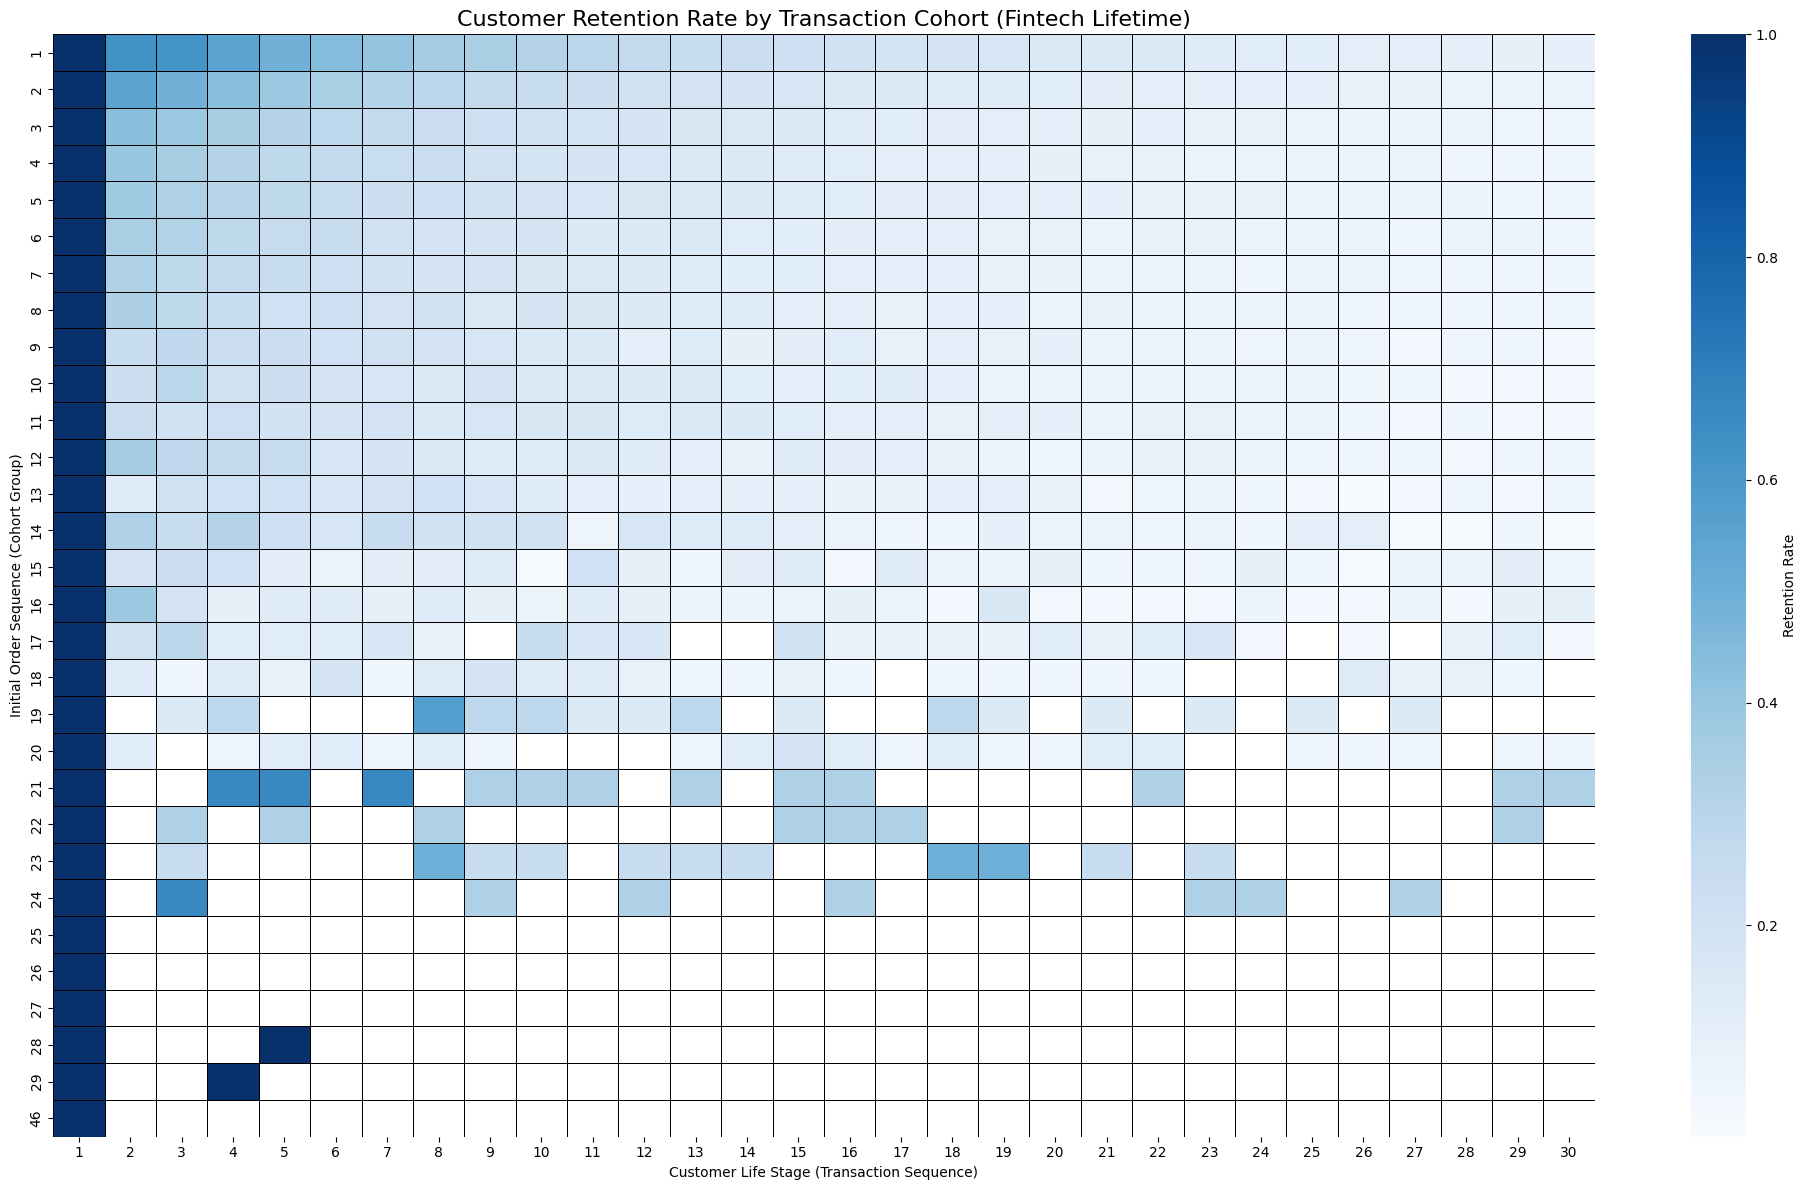

In [18]:
# Plotting the Retention Heatmap
plt.figure(figsize=(20, 12))
sns.heatmap(
    retention_matrix.iloc[:30, :30], # Limit to first 30 cohorts/months for visualization clarity
    annot=False, 
    fmt='.1%', 
    cmap='Blues', 
    linecolor='black', 
    linewidths=.5,
    cbar_kws={'label': 'Retention Rate'}
)
plt.title('Customer Retention Rate by Transaction Cohort (Fintech Lifetime)', fontsize=16)
plt.ylabel('Initial Order Sequence (Cohort Group)')
plt.xlabel('Customer Life Stage (Transaction Sequence)')
plt.tight_layout()

In [19]:
# Save the primary portfolio visualization
HEATMAP_FILE = os.path.join(VIS_PATH, 'Cohort_Retention_Heatmap.png')
plt.savefig(HEATMAP_FILE)

<Figure size 640x480 with 0 Axes>

### Merchant vertical mapping

In [20]:
# This step groups the 21 raw department IDs into 7 business-relevant 'Fintech Verticals'.
def map_to_fintech_vertical(department_name):
    if department_name in ['produce', 'dairy eggs', 'beverages', 'meat seafood', 'deli', 'bakery', 'pantry', 'frozen']:
        return '01_Groceries_Core' # Essential, frequent spending
    elif department_name in ['snacks', 'dry goods pasta', 'breakfast', 'canned goods', 'international']:
        return '02_Food_Specialty' # Less essential, discretionary food spend
    elif department_name in ['household', 'pets', 'bulk', 'babies']:
        return '03_Home_and_Care' # Regular, non-food subscription/household spend
    elif department_name in ['personal care']:
        return '04_Health_Wellness' # Targeted personal spending
    elif department_name in ['other', 'missing', 'alcohol']:
        return '05_Discretionary_Other' # Low volume, high variability
    else:
        return '06_Undefined' # Should not happen, but kept for robustness

In [21]:
# Apply the mapping to the transaction log
transaction_log['Fintech_Vertical'] = transaction_log['department'].apply(map_to_fintech_vertical)

In [22]:
# Verify the new mapping
vertical_map = transaction_log[['department', 'Fintech_Vertical']].drop_duplicates().sort_values(by='Fintech_Vertical')

In [23]:
%pip install tabulate

# Final Merchant vertical map for powerBI
import tabulate
print(vertical_map.to_markdown(index=False))

Note: you may need to restart the kernel to use updated packages.
| department      | Fintech_Vertical       |
|:----------------|:-----------------------|
| pantry          | 01_Groceries_Core      |
| dairy eggs      | 01_Groceries_Core      |
| produce         | 01_Groceries_Core      |
| bakery          | 01_Groceries_Core      |
| deli            | 01_Groceries_Core      |
| beverages       | 01_Groceries_Core      |
| meat seafood    | 01_Groceries_Core      |
| frozen          | 01_Groceries_Core      |
| breakfast       | 02_Food_Specialty      |
| dry goods pasta | 02_Food_Specialty      |
| international   | 02_Food_Specialty      |
| snacks          | 02_Food_Specialty      |
| canned goods    | 02_Food_Specialty      |
| household       | 03_Home_and_Care       |
| pets            | 03_Home_and_Care       |
| babies          | 03_Home_and_Care       |
| bulk            | 03_Home_and_Care       |
| personal care   | 04_Health_Wellness     |
| missing         | 05_Discretiona

### Customer feature set

In [24]:
# Calculate Usage Diversity: The number of unique Fintech Verticals used by each customer
usage_diversity = transaction_log.groupby('Customer_ID')['Fintech_Vertical'].nunique().reset_index()
usage_diversity.rename(columns={'Fintech_Vertical': 'Usage_Diversity_Count'}, inplace=True)

In [25]:
# Merge the Usage Diversity back to the customer features file
customer_features_df = customer_features_df.merge(usage_diversity, on='Customer_ID', how='left')

In [26]:
# Save the enriched customer features
customer_features_df.to_csv(OUTPUT_FEATURES, index=False)